In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
print(torch.__version__)

1.4.0


config

In [2]:
# we assume all r are 0
i_dim = 5
o_dim = 5
h_dim = 10
LR_D = 1e-3
LR_G = 1e-3
LR_A = 1e-4
r_dim = 2 * o_dim
n_samples = 100000
n_steps = 10000
batch_size = 100
alpha = 0.00

networks

In [3]:
G = nn.Sequential(                      # Generator
    nn.Linear(i_dim, h_dim),            # random ideas (could from normal distribution)
    nn.ReLU(inplace=False),
    nn.Linear(h_dim, h_dim),    
    nn.ReLU(inplace=False),
    nn.Linear(h_dim, o_dim),     
)

In [4]:
D = nn.Sequential(                      # Discriminator
    nn.Linear(o_dim, 2*o_dim),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(inplace=False),
    nn.Linear(2*o_dim, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

In [5]:
A = nn.Sequential(
    nn.Linear(o_dim, h_dim),
    nn.ReLU(inplace=False),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(inplace=False),
    nn.Linear(h_dim, r_dim),
)

optimizer

In [6]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)
opt_A = torch.optim.Adam(A.parameters(), lr=LR_A)

Dataset

In [7]:
m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(o_dim), torch.eye(o_dim))

In [8]:
samples = []
for i in range(n_samples):
    samples.append(torch.abs(m.sample()))
samples = torch.stack(samples)

In [9]:
samples.size()

torch.Size([100000, 5])

In [10]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample

In [11]:
train_dataset = MultivariateNormalDataset(samples)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

training

In [12]:
def pick_samples(samples, u):
    flag_list = []
#     print(samples.size())
    for i in range(len(u)):
        flag = samples[:,i] > u[i]
        flag_list.append(flag)
#         print(flag)

    flags = torch.stack(flag_list, dim=1)
    
#     print('flags', flags.size())
    
    flags.max()
        
    
        
    total_flag = samples[:,0] < -np.inf
    
    for i in range(len(u)):
        total_flag = total_flag | flag_list[i]
        
#     print(total_flag)
        
    return samples[total_flag,:]

In [13]:
# initialize

# agg_list = []

# for i, input_ in enumerate(train_dataloader):
#     agg_list.append(A(input_))
    
paras = torch.ones(2*o_dim)
e = torch.distributions.exponential.Exponential(torch.ones(o_dim))
print(paras)

n_extremes_list = []
acc_list = []

for step in range(n_steps):
    input_ = next(iter(train_dataloader))
    paras_val = A(input_)
    paras_incre = torch.mean(torch.abs(paras_val),dim=0)
#     print(paras_incre.size())
    ratio = batch_size*1.0/n_samples
    paras = (1 - ratio) * paras + ratio * paras_incre
    
    u = paras[0:o_dim] + 2
    sigma = paras[o_dim:] + 0.05
#     print(paras)
#     print(u)
#     print(sigma)
    
    extreme_samples = pick_samples(samples, u) - u
    
#     print('extreme_samples', extreme_samples.size())
    
    n_extremes = len(extreme_samples)
    
    n_extremes_list.append(n_extremes)
    
#     print('n_extremes size', n_extremes)
    
    G_noise = torch.randn(n_extremes, i_dim, requires_grad=True)
    G_samples = G(G_noise)
    
#     print('G_samples', G_samples.size())
    
    
    max_value, _ = torch.max(G_samples, dim=1)
    
#     print(torch.max(G_samples, dim=1))
    max_value = max_value.unsqueeze(-1)
    
#     print('G_samples', G_samples.size())
#     print('max_value', max_value.size())
    

    
    G_samples = G_samples - max_value
    
#     print('G_samples', G_samples.size())
    
#     print(torch.topk(-G_samples, o_dim, dim=1))

#     G_samples = G_samples[:,:o_dim]
    
#     G_samples = -torch.topk(-G_samples, o_dim, dim=1).values
    
#     print('G_samples', G_samples.size())
#     print(G_samples)

    
    e_samples = e.rsample([len(G_samples)])
    
#     print('e_samples', e_samples.size())
#     for i in range(len(G_samples)):
#         e_samples.append(e.sample())
        
    
#     e_samples = torch.stack(e_samples)
        
        
#     # TODO    
#     #e_samples = 
    
    G_extrems = sigma * (G_samples + e_samples)
    
#     print('G_extrems', G_extrems.size())
    
    prob_G_extrems = D(G_extrems)
    G_loss = torch.mean(torch.log(1. - prob_G_extrems)) + alpha * torch.norm(u)
    opt_G.zero_grad()
    opt_A.zero_grad()
    G_loss.backward(retain_graph=True)
    opt_G.step()
    opt_A.step()
    
    
    
    prob_R = D(extreme_samples)
    prob_G = D(G_extrems.detach()) 
    D_loss = - torch.mean(torch.log(prob_R) + torch.log(1. - prob_G))
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()
        
    
    n_correct = torch.sum(prob_R >= 0.5) + torch.sum(prob_G < 0.5)
    acc = n_correct *1.0 / (2 * n_extremes)
    
    acc_list.append(acc)
    
    if step%100==0:
        print('n_extremes size', n_extremes)
        print('{}th step, parameters are {}'.format(step, paras))

    
    
#     prob_artist0 = D(artist_paintings)          # D try to increase this prob
#     prob_artist1 = D(G_paintings.detach())  # D try to reduce this prob
#     D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
#     opt_D.zero_grad()
#     D_loss.backward(retain_graph=True)      # reusing computational graph
#     opt_D.step()
    



tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
n_extremes size 1340
0th step, parameters are tensor([0.9990, 0.9990, 0.9991, 0.9991, 0.9993, 0.9991, 0.9993, 0.9993, 0.9993,
        0.9990], grad_fn=<AddBackward0>)
n_extremes size 1785
100th step, parameters are tensor([0.9072, 0.9069, 0.9084, 0.9154, 0.9348, 0.9144, 0.9278, 0.9324, 0.9298,
        0.9082], grad_fn=<AddBackward0>)
n_extremes size 2271
200th step, parameters are tensor([0.8267, 0.8263, 0.8325, 0.8432, 0.8735, 0.8399, 0.8548, 0.8758, 0.8691,
        0.8345], grad_fn=<AddBackward0>)
n_extremes size 2796
300th step, parameters are tensor([0.7551, 0.7502, 0.7708, 0.7742, 0.8153, 0.7699, 0.7859, 0.8218, 0.8044,
        0.7846], grad_fn=<AddBackward0>)
n_extremes size 3353
400th step, parameters are tensor([0.6907, 0.6808, 0.7171, 0.7105, 0.7596, 0.7028, 0.7205, 0.7755, 0.7386,
        0.7428], grad_fn=<AddBackward0>)
n_extremes size 3942
500th step, parameters are tensor([0.6320, 0.6192, 0.6581, 0.6499, 0.7144, 0.6426, 0.67

KeyboardInterrupt: 

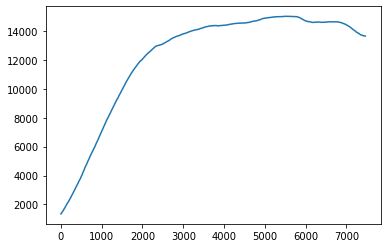

In [14]:
plt.plot(n_extremes_list)
plt.show()

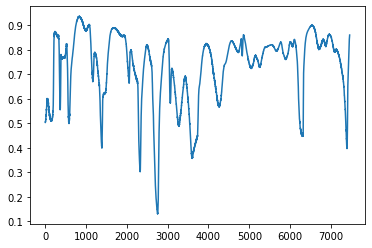

In [15]:
plt.plot(acc_list)
plt.show()

In [16]:
print(min(n_extremes_list))

1340


In [17]:
print(max(acc_list))

tensor(0.9369)
